연습문제 2. U-Net 구축해보기
==============================
> U-Net를 구축해보고 AutoEncoder와 차이점을 설명하시오.

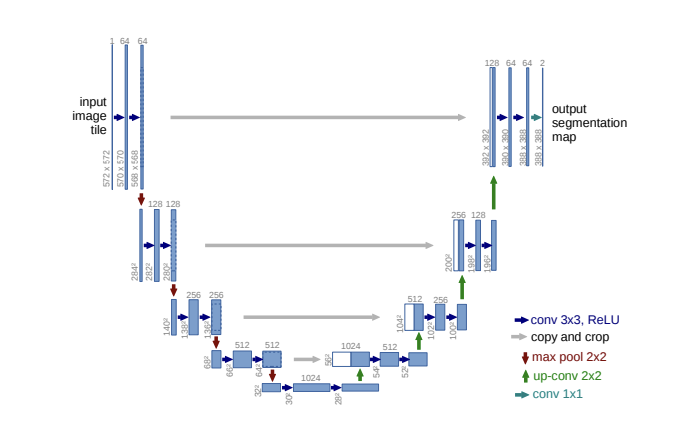

In [2]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm.auto import tqdm

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", device)

Using Device: cuda


In [3]:
epochs = 10
batch_size = 256
learning_rate = 0.001

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize(64)])

dataset = datasets.FashionMNIST(root = './data/', train = True, download = True, transform = transform)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
data_loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

In [5]:
labels_num = dataset.targets.numpy()
labels = [class_names[i] for i in labels_num]

In [6]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1,64,3, padding =1),
            nn.ReLU(),
            nn.Conv2d(64,64,3, padding =1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64,128,3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128,128,3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128,256,3, padding =1),
            nn.ReLU(),
            nn.Conv2d(256,256,3, padding =1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.middle = nn.Sequential(
            nn.Conv2d(256,512,3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512,256,3, padding = 1),
            nn.ReLU(),
        )
        
        self.decoder1 = nn.Sequential(
            nn.Conv2d(512,256,3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256,3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(256,128,2,2,0),
        )
        
        self.decoder2 = nn.Sequential(
            nn.Conv2d(256,128,3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128,128,3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128,64,2,2,0),
        )
        
        self.decoder3 = nn.Sequential(
            nn.Conv2d(128,64,3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64,64,3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64,1,2,2,0),
        )

    def forward(self, x):
        encoded1 = self.encoder1(x)
        encoded2 = self.encoder2(encoded1)
        encoded3 = self.encoder3(encoded2)
        
        mid = self.middle(encoded3)
        
        # print('e1',encoded1.shape)
        # print('e2',encoded2.shape)
        # print('e3',encoded3.shape)
        # print('m',mid.shape)
        
        decoded1 = self.decoder1(torch.cat((mid, encoded3), dim = 1))
        # print('d1',decoded1.shape)
        
        decoded2 = self.decoder2(torch.cat((decoded1, encoded2), dim = 1))
        # print('d2',decoded2.shape)
        
        decoded3 = self.decoder3(torch.cat((decoded2, encoded1), dim = 1))
        
        return encoded3, decoded3


In [7]:
model = UNet().to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [8]:
loss_list = []
for epoch in tqdm(range(1, epochs+1)):
    loss_value = 0
    for step, (x, label) in enumerate(data_loader):
        model.train()
        x = x.to(device)
        y = x.to(device)
        label = label.to(device)

        encoded, decoded = model(x)

        loss = criterion(decoded, y)
        loss_value += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(loss_value)
    print("Epoch : ", epoch, ', Loss : ', loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch :  1 , Loss :  0.000232408638112247
Epoch :  2 , Loss :  0.00014492636546492577
Epoch :  3 , Loss :  6.30861904937774e-05
Epoch :  4 , Loss :  5.3007981478003785e-05
Epoch :  5 , Loss :  4.759056537295692e-05
Epoch :  6 , Loss :  3.890870721079409e-05
Epoch :  7 , Loss :  3.144050424452871e-05
Epoch :  8 , Loss :  5.422661706688814e-05
Epoch :  9 , Loss :  0.0003023341705556959
Epoch :  10 , Loss :  9.639124618843198e-05


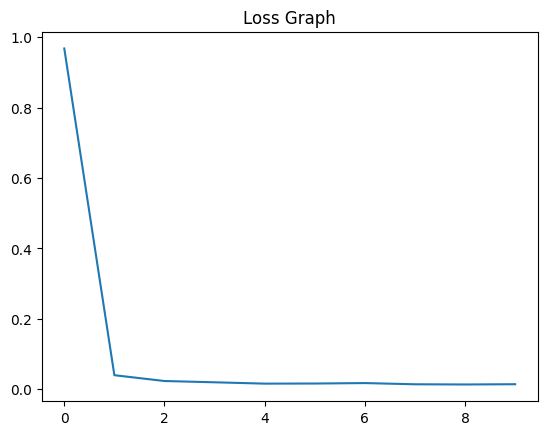

In [9]:
plt.title('Loss Graph')
plt.plot(loss_list)

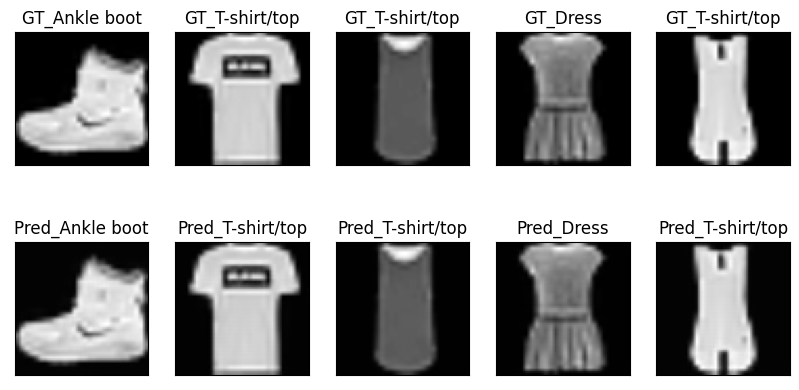

In [10]:
resize = transforms.Resize(64)
sample_image = resize(dataset.data[:5]).unsqueeze(1)
sample_image = sample_image.type(torch.FloatTensor)/255.
sample_label = dataset.targets[:5]

with torch.no_grad():
    model=model.to(device)
    model.eval()
    test_image = sample_image.to(device)
    encode_result, decode_result = model(test_image)

f, a = plt.subplots(2, 5, figsize=(10, 5))


for i in range(5):
    img = np.reshape(sample_image.data.numpy()[i],(64, 64)) 
    a[0][i].imshow(img, cmap='gray')
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())
    a[0][i].set_title('GT_'+class_names[sample_label[i]])

for i in range(5):
    img = np.reshape(decode_result.to("cpu").data.numpy()[i], (64, 64)) 
    a[1][i].imshow(img, cmap='gray')
    a[1][i].set_xticks(())
    a[1][i].set_yticks(())
    a[1][i].set_title('Pred_'+class_names[sample_label[i]])
plt.show()